## Module Imports

In [269]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

from sklearn.model_selection import train_test_split
from joblib import dump,load
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

import pickle

### Mount Google Drive to Google Colab

In [270]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

### **Identify datasets with NaN or None values**

In [271]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
db = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Week1_challenge_data_source(CSV).csv', na_values=['undefined','?', None])
# db.head() # the fisrt five rows

# Size of the dataset
### Columns of the dataset

In [272]:
# list of column  names
# db.columns.tolist()

### Number of columns

In [273]:
# print(f"Number of columns: ", len(db.columns))

### Number of data points and data size

In [274]:
# print(f" There are {db.shape[0]} rows and {db.shape[1]} columns")

### Features/columns and their data type

In [275]:
# db.dtypes

### Min and Max values of each column

In [276]:
# db.max()

In [277]:
# db.min()

### Utility Functions

In [278]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The dataset contains", round(((totalMissing/totalCells) * 100), 3), "%", "missing values.")


# Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# fill missing numeric values with mean and object type values with mode
def fill_missing_values(df):
  for column in df.columns:
    if df[column].dtype == 'float64':
      df[column] = df[column].fillna(df[column].mean())
    elif df[column].dtypes == 'object':
      df[column] = df[column].fillna(df[column].mode()[0])
  return df


def format_float(value):
    return f'{value:,.2f}'

def find_agg(df:pd.DataFrame, agg_column:str, agg_metric:str, col_name:str, top:int, order=False )->pd.DataFrame:
    
    new_df = df.groupby(agg_column)[agg_column].agg(agg_metric).reset_index(name=col_name).\
                        sort_values(by=col_name, ascending=order)[:top]
    
    return new_df

def convert_bytes_to_megabytes(df, bytes_data):
    """
        This function takes the dataframe and the column which has the bytes values
        returns the megabytesof that value
        
        Args:
        -----
        df: dataframe
        bytes_data: column with bytes values
        
        Returns:
        --------
        A series
    """
    
    megabyte = 1*10e+5
    df[bytes_data] = df[bytes_data] / megabyte
    return df[bytes_data]

def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]


###################################PLOTTING FUNCTIONS###################################

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()
    
def plot_bar(df:pd.DataFrame, x_col:str, y_col:str, title:str, xlabel:str, ylabel:str)->None:
    plt.figure(figsize=(12, 7))
    sns.barplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

def plot_heatmap(df:pd.DataFrame, title:str, cbar=False)->None:
    plt.figure(figsize=(12, 7))
    sns.heatmap(df, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', linewidths=.7, cbar=cbar )
    plt.title(title, size=18, fontweight='bold')
    plt.show()

def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()


pd.options.display.float_format = format_float

In [279]:
percent_missing(db)

The dataset contains 12.72 % missing values.


### Missing Value table

In [280]:
# missing_values_table(db)

### Columns with missing values count

The Column "Nb of sec with 37500B < Vol UL" has maximum missing values of 130254 occurances

In [281]:
# db.isna().sum() # missing values of each column

In [282]:
# print ("Maximum missing values per column: ", np.max(db.isna().sum())) # print(db.isna().sum().max())

# Exploratory Data Analysis

Use Mode method to fill the missing datapoints of all 'object' type features and Mean/Median methods for all numuric type features.
*   use Median method for skewed(negative/positive) numeric feature and 
*   use MEAN/Median for non-skewd/symetrical numeric feature


### Method selection based on data skewness

#### Skewness of each column

In [283]:
# db.skew(axis=0)

### Skewness visualization with histogram

In [284]:
# db['Total UL (Bytes)'].hist()

### Positively skewed parameter

In [285]:
# db['UL TP < 10 Kbps (%)'].hist()

### Negatively skewwed parameter

In [286]:
# db['UL TP < 10 Kbps (%)'].hist()

### Data with total missing values in each column - revisited

In [287]:
# db.isna().sum()

### Fill missing values
* numeric missing values with mean method
* object type missing values with mode method

In [421]:
fill_missing_values(db).isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

### Other method of handling missing values - Interpolation
* We can use interpolation while working with time-series data because in time-series data we like to fill missing values with previous one or two values.
* It can be used to estimate unknown data points between two known data points.

##### Since we are not considering the time-series nature of the telecom data, we choose not to use interpolation here.

In [289]:
# db.interpolate(inplace=True)

In [290]:
# db.isna().sum()

# Data Transformation
**Scaling and Normalization**

##### Scaling - changing the range of your data 
##### Normalization, you're changing the shape of the distribution of your data.

#### Scaling

* This transforms data so that it fits within a specific scale, like 0-100 or 0-1. 
* It is important when we're using methods based on distance measures of data points like support vector machines (SVM) or k-nearest neighbors (KNN).
* We use the scaler method from sklearn.

#### Normalization

Scaling just changes the range of your data. Normalization is a more radical transformation. The point of normalization is to change your observations so that they can be described as a normal distribution.

* Normal distribution ("bell curve", Gaussian distribution) is a specific statistical distribution where a roughly equal observations fall above and below the mean
 * The mean and the median are the same, and there are more observations closer to the mean.

* In general, you'll normalize your data if you're going to be using a machine learning or statistics technique like LDA and Gaussian naive Bayes that assumes your data is normally distributed. Some examples of these include linear discriminant analysis (LDA) and Gaussian naive Bayes. (Pro tip: any method with "Gaussian" in the name probably assumes normality.)

* We usee the Normalizer method from sklearn



### Numeric Value Scaling

In [291]:
minmax_scaler = preprocessing.MinMaxScaler()
def scalling_numeric_values(df):
  col_values = []
  col_exclude = ['Bearer Id', 'IMSI','MSISDN/Number','IMEI']
  for column in df.columns:
    if df[column].dtype == 'float64' and (column not in col_exclude):
      col_values.append(list(df[column].values))
  col_values_scaled = minmax_scaler.fit_transform(col_values)
  db_scaled = pd.DataFrame(col_values_scaled)
  return df

In [422]:
db_sklearn = fill_missing_values(db.copy())
scalling_numeric_values(db_sklearn)
db_sklearn

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",4/4/2019 12:01,770.00,4/25/2019 14:35,662.00,"1,823,652.00","208,201,448,079,117.00","33,664,962,239.00","35,521,209,507,511.00",9.16456699548519E+015,42.00,5.00,23.00,44.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38","37,624.00","38,787.00","1,823,652,892.00",Samsung,Samsung Galaxy A5 Sm-A520F,989.70,340.43,810.84,149.26,965.46,141.30,213.00,214.00,"1,545,765.00","24,420.00","1,634,479.00","1,271,433.00","3,563,542.00","137,762.00","15,854,611.00","2,501,332.00","8,198,936.00","9,656,251.00","278,082,303.00","14,344,150.00","171,744,450.00","8,814,393.00","36,749,741.00","308,879,636.00"
1,"13,114,483,482,878,900,224.00",4/9/2019 13:04,235.00,4/25/2019 8:15,606.00,"1,365,104.00","208,201,909,211,140.00","33,681,854,413.00","35,794,009,006,359.00",L77566A,65.00,5.00,16.00,26.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38",168.00,"3,560.00","1,365,104,371.00",Samsung,Samsung Galaxy J5 (Sm-J530),989.70,340.43,810.84,149.26,965.46,141.30,971.00,"1,022.00","1,926,113.00","7,165.00","3,493,924.00","920,172.00","629,046.00","308,339.00","20,247,395.00","19,111,729.00","18,338,413.00","17,227,132.00","608,750,074.00","1,170,709.00","526,904,238.00","15,055,145.00","53,800,391.00","653,384,965.00"
2,"13,114,483,484,080,500,736.00",4/9/2019 17:42,1.00,4/25/2019 11:58,652.00,"1,361,762.00","208,200,314,458,056.00","33,760,627,129.00","35,281,510,359,387.00",D42335A,109.80,17.66,6.00,9.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38",0.00,0.00,"1,361,762,651.00",Samsung,Samsung Galaxy A8 (2018),989.70,340.43,810.84,149.26,965.46,141.30,751.00,695.00,"1,684,053.00","42,224.00","8,535,055.00","1,694,064.00","2,690,151.00","672,973.00","19,725,661.00","14,699,576.00","17,587,794.00","6,163,408.00","229,584,621.00","395,630.00","410,692,588.00","4,215,763.00","27,883,638.00","279,807,335.00"
3,"13,114,483,485,442,799,616.00",4/10/2019 0:31,486.00,4/25/2019 7:36,171.00,"1,321,509.00","208,201,402,342,131.00","33,750,343,200.00","35,356,610,164,913.00",T21824A,109.80,17.66,44.00,44.00,"20,809,914.27","759,658.66",100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,"114,471,023.70","3,242,301.38","3,330.00","37,882.00","1,321,509,685.00",Apple,Huawei B528S-23A,989.70,340.43,810.84,149.26,965.46,141.30,17.00,207.00,"644,121.00","13,372.00","9,023,734.00","2,788,027.00","1,439,754.00","631,229.00","21,388,122.00","15,146,643.00","13,994,646.00","1,097,942.00","799,538,153.00","10,849,722.00","749,039,933.00","12,797,283.00","43,324,218.00","846,028,530.00"
4,"13,114,483,499,480,700,928.00",4/12/2019 20:10,565.00,4/25/2019 10:40,954.00,"1,089,009.00","208,201,401,415,120.00","33,699,795,932.00","35,407,009,745,539.00",D88865A,109.8

### Scaling between [0,1]

In [431]:
def scalling_numeric_values_0_1(df):
  for column in df.columns:
    col_exclude = ['Bearer Id', 'IMSI','MSISDN/Number','IMEI']
    if df[column].dtype == 'float64' and (column not in col_exclude):
      df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(150001,1))
  return df

In [432]:
db_sklearn = fill_missing_values(db.copy())
scalling_numeric_values_0_1(db_sklearn)

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",4/4/2019 12:01,0.77,4/25/2019 14:35,0.66,0.98,"208,201,448,079,117.00","33,664,962,239.00","35,521,209,507,511.00",9.16456699548519E+015,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,Samsung,Samsung Galaxy A5 Sm-A520F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.43,0.37,0.14,0.31,0.99,0.15,0.68,0.11,0.35,0.44,0.33,0.87,0.20,0.53,0.45,0.34
1,"13,114,483,482,878,900,224.00",4/9/2019 13:04,0.24,4/25/2019 8:15,0.61,0.73,"208,201,909,211,140.00","33,681,854,413.00","35,794,009,006,359.00",L77566A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.73,Samsung,Samsung Galaxy J5 (Sm-J530),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.54,0.11,0.30,0.22,0.18,0.33,0.87,0.87,0.79,0.78,0.72,0.07,0.62,0.91,0.67,0.72
2,"13,114,483,484,080,500,736.00",4/9/2019 17:42,0.00,4/25/2019 11:58,0.65,0.73,"208,200,314,458,056.00","33,760,627,129.00","35,281,510,359,387.00",D42335A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.73,Samsung,Samsung Galaxy A8 (2018),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.47,0.64,0.74,0.41,0.75,0.72,0.85,0.67,0.76,0.28,0.27,0.02,0.49,0.25,0.33,0.30
3,"13,114,483,485,442,799,616.00",4/10/2019 0:31,0.49,4/25/2019 7:36,0.17,0.71,"208,201,402,342,131.00","33,750,343,200.00","35,356,610,164,913.00",T21824A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,Apple,Huawei B528S-23A,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.18,0.20,0.79,0.68,0.40,0.67,0.92,0.69,0.60,0.05,0.95,0.66,0.89,0.77,0.54,0.94
4,"13,114,483,499,480,700,928.00",4/12/2019 20:10,0.57,4/25/2019 10:40,0.95,0.58,"208,201,401,415,120.00","33,699,795,932.00","35,407,009,745,539.00",D88865A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,Samsung,Samsung Sm-G390F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.24,0.76,0.55,0.36,0.54,0.19,0.66,0.86,0.74,0.02,0.63,0.21,0.65,0.84,0.47,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,"7,277,825,670,196,679,680.00",4/29/2019 7:28,0.45,4/30/2019 6:02,0.21,0.04,"208,202,201,200,072.00","33,650,688,697.00","35,483,109,451,938.00",D20434A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,Apple,Apple iPhone 8 Plus (A1897),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.97,0.79,0.87,0.68,0.02,0.68,0.70,0.53,0.77,0.89,0.62,0.56,0.00,0.81,0.73,0.63
149997,"7,349,883,264,234,609,664.00",4/29/2019 7:28,0.48,4/30/2019 10:41,0.19,0.05,"208,201,908,153,249.00","33,663,449,963.00","35,660,508,296,467.00",D10223C,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,

### Mean and Mediam of some vital attributes

In [295]:
important_columns_numeric = ['Bearer Id','Dur. (ms)','MSISDN/Number',
                      'Avg RTT DL (ms)','Avg RTT UL (ms)',
                      'TCP DL Retrans. Vol (Bytes)','TCP UL Retrans. Vol (Bytes)',
                      'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                      'Google DL (Bytes)', 'Google UL (Bytes)', 
                      'Email DL (Bytes)','Email UL (Bytes)',
                      'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                      'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 
                      'Gaming DL (Bytes)','Gaming UL (Bytes)',
                      'Other DL (Bytes)', 'Other UL (Bytes)',
                      'Total UL (Bytes)', 'Total DL (Bytes)' ]

important_columns_object = ['Handset Manufacturer','Handset Type']


In [296]:
# db[important_columns_numeric].mean() #mean of numeric columns

In [297]:
# db[important_columns_numeric].median()

In [298]:
# db[important_columns_object].mode()

# User Overview Analysis


## Univariate Analysis
* Numric Univaraite Analysis
* Categorical Univariate Analysis


### Numeric Univariate EDA

In [299]:
# db_explore = db.copy()
# fix_outlier(db_explore, "MSISDN/Number")

In [300]:
# plot_hist(db_explore.head(10000),"MSISDN/Number" ,'green')

In [301]:
# plot_hist(db_explore, "Dur. (ms)", "green")

In [302]:
# plot_hist(db_explore, "Bearer Id", "green")

In [303]:
# plot_hist(db_explore, "Avg RTT DL (ms)", "green")


In [304]:
# plot_hist(db_explore, "Avg RTT UL (ms)", "green")


In [305]:
# plot_hist(db_explore.head(50000), "Handset Manufacturer", "blue")


In [306]:
# plot_hist(db_explore.head(50000), "Handset Type", "blue")


In [307]:
# plot_hist(db_explore, "Social Media DL (Bytes)", "green")


In [308]:
# sns.histplot(x=columns[0], data =db) # this also works
# plot_hist(db_explore, "Social Media UL (Bytes)", "green")


In [309]:
# plot_hist(db_explore, "Total DL (Bytes)", "green")


In [310]:
# plot_hist(db_explore, "Total UL (Bytes)", "green")


In [311]:
# plot_box(db_explore, "Dur. (ms)", "Session Duration Outliers")

In [312]:
# plot_box(db_explore, "Avg RTT DL (ms)", "Avg RTT DL (ms) Outliers")


In [313]:
# plot_box(db_explore, "Avg RTT UL (ms)", "Avg RTT UL (ms) Outliers")

In [314]:
# plot_box(db_explore, "TCP DL Retrans. Vol (Bytes)", "TCP DL Retrans. Vol (Bytes) Outliers")


In [315]:
# plot_box(db_explore, "TCP UL Retrans. Vol (Bytes)", "TCP UL Retrans. Vol (Bytes) Outliers")


In [316]:
# plot_box(db_explore, "Social Media DL (Bytes)", "Social Media DL (Bytes) Outliers")


In [317]:
# plot_box(db_explore, "Social Media UL (Bytes)", "Social Media UL (Bytes) Outliers")


In [318]:
# plot_box(db_explore, "Total DL (Bytes)", "Total DL (Bytes) Outliers")

In [319]:
# plot_box(db_explore, "Total UL (Bytes)", "Total UL (Bytes) Outliers")

### Categorical Univariate EDA

In [320]:
# plot_count(db_explore, "Handset Manufacturer")


In [321]:
# plot_count(db_explore, "Handset Type")

### Non-Graphical Univariate EDA

In [322]:
# db.describe()

In [323]:
# db["Total DL (Bytes)"].describe()


In [324]:
# db["Total UL (Bytes)"].describe()


In [325]:
# db["MSISDN/Number"].describe()


In [326]:
# db.info()

In [327]:
# db.isna().sum()


In [328]:
# db_explore_100 = db_explore.head(100)


## Bivariate Analysis
#### Applications Vs Total DL and Total UL

In [329]:
# sns.barplot(x='Total DL (Bytes)',y='Social Media DL (Bytes)',data=db_explore_100)



In [330]:
# sns.barplot(x='Total DL (Bytes)',y='Social Media UL (Bytes)',data=db_explore.head(1000))


In [331]:
# sns.barplot(x='Total DL (Bytes)',y='Social Media UL (Bytes)',data=db_explore_100)


In [332]:
# sns.barplot(x='Total UL (Bytes)',y='Social Media DL (Bytes)',data=db_explore_100)


In [333]:
# sns.barplot(x='Total UL (Bytes)',y='Social Media UL (Bytes)',data=db_explore_100)


In [334]:
# sns.regplot(x='Total DL (Bytes)',y='Google DL (Bytes)',data=db_explore_100)


In [335]:
# sns.regplot(x='Total DL (Bytes)',y='Google UL (Bytes)',data=db_explore_100)


In [336]:
# sns.regplot(x='Total UL (Bytes)',y='Google DL (Bytes)',data=db_explore_100)

In [337]:
# sns.regplot(x='Total UL (Bytes)',y='Google UL (Bytes)',data=db_explore_100)


In [338]:
# sns.stripplot(x='Total DL (Bytes)',y='Email DL (Bytes)',data=db_explore_100)


In [339]:
# sns.stripplot(x='Total DL (Bytes)',y='Email UL (Bytes)',data=db_explore_100)
# sns.stripplot(x='Total UL (Bytes)',y='Email DL (Bytes)',data=db_explore_100)


In [340]:
# sns.stripplot(x='Total UL (Bytes)',y='Email UL (Bytes)',data=db_explore_100)


In [341]:
# sns.regplot(x='Total DL (Bytes)',y='Youtube DL (Bytes)',data=db_explore_100)


In [342]:
# sns.regplot(x='Total DL (Bytes)',y='Youtube UL (Bytes)',data=db_explore_100)


In [343]:
# sns.regplot(x='Total UL (Bytes)',y='Youtube DL (Bytes)',data=db_explore_100)


In [344]:
# sns.regplot(x='Total UL (Bytes)',y='Youtube UL (Bytes)',data=db_explore_100)


In [345]:
# sns.barplot(x='Total DL (Bytes)',y='Netflix DL (Bytes)',data=db_explore_100)


In [346]:
# sns.barplot(x='Total DL (Bytes)',y='Netflix UL (Bytes)',data=db_explore_100)


In [347]:
# sns.barplot(x='Total UL (Bytes)',y='Netflix DL (Bytes)',data=db_explore_100)


In [348]:
# sns.barplot(x='Total UL (Bytes)',y='Netflix UL (Bytes)',data=db_explore_100)


In [349]:
# sns.regplot(x='Total DL (Bytes)',y='Gaming DL (Bytes)',data=db_explore_100)


In [350]:
# sns.regplot(x='Total DL (Bytes)',y='Gaming UL (Bytes)',data=db_explore_100)


In [351]:
# sns.regplot(x='Total UL (Bytes)',y='Gaming DL (Bytes)',data=db_explore_100)


In [352]:
# sns.regplot(x='Total UL (Bytes)',y='Gaming UL (Bytes)',data=db_explore_100)


In [353]:
# sns.regplot(x='Total DL (Bytes)',y='Other DL (Bytes)',data=db_explore_100)


In [354]:
# sns.regplot(x='Total DL (Bytes)',y='Other UL (Bytes)',data=db_explore_100)


In [355]:
# sns.regplot(x='Total UL (Bytes)',y='Other DL (Bytes)',data=db_explore_100)


In [356]:
# sns.regplot(x='Total UL (Bytes)',y='Other UL (Bytes)',data=db_explore_100)

##Multivariate Analysis

In [357]:
# plot_scatter(db_explore.head(100), x_col="MSISDN/Number", y_col="Social Media DL (Bytes)", hue="Social Media UL (Bytes)",
#              style="Social Media UL (Bytes)", title="Social media DL consumption per user")


In [358]:
# plot_scatter(db_explore.head(100), x_col="MSISDN/Number", y_col="Total DL (Bytes)", hue="Total UL (Bytes)",
#              style="Total UL (Bytes)", title="Total DL consumption per user")


In [359]:
# plot_box_multi(db_explore.head(100), x_col="MSISDN/Number", y_col="TCP DL Retrans. Vol (Bytes)", 
#                title="TCP DL Retrans. Vol (Bytes) outilers in MSISDN/Number column")


In [360]:
# dfPair = db_explore.head(50)[["MSISDN/Number", "Dur. (ms)", "Avg RTT DL (ms)", "Social Media DL (Bytes)", "Total DL (Bytes)"]]


In [361]:
# sns.pairplot(dfPair, hue = 'Total DL (Bytes)', diag_kind = 'kde',
#              plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
#              height=4)


In [362]:
# dfPair = db_explore.head(50)[["MSISDN/Number", "Dur. (ms)", "Avg RTT DL (ms)", "Social Media DL (Bytes)", "Total DL (Bytes)"]]
# sns.pairplot(dfPair, hue = 'Total DL (Bytes)', diag_kind = 'kde',height=4)

# Deciles

### Decile Columns

In [363]:
# decile_columns = ['MSISDN/Number','Dur. (ms)','Total UL (Bytes)', 'Total DL (Bytes)' ] # to limit the number of columns to be displayed
# db_decile = db_explore[decile_columns]
# # db_decile_group["Dur. Decile"] = pd.qcut(db_decile_group['Dur. (ms)'], 5, labels = ['Dec 1','Dec 2','Dec 3','Dec 4','Dec 5'])
# # db_decile_group

### Five MSISDN deciles based on xDR Duration
#### contains all selected columns

In [364]:
# db_decile_group_dur = db_decile.groupby(pd.qcut(db_decile["Dur. (ms)"], 5))
# db_decile_group_dur.describe() # includes all selected columns

### Deciles based on xDR duration
### Contains only the xDR duration data

In [365]:
# db_decile_group_dur['Dur. (ms)'].describe() 

### Decile Total DL Bytes sum




In [366]:
# db_decile_group_dur['Total DL (Bytes)'].sum()

### Decile Total UL Bytes sum


In [367]:
# db_decile_group_dur['Total UL (Bytes)'].sum() 

## Correlation Analysis

### Correlation Analysis for the whole data


In [368]:
# db.corr(method='pearson')

### Correlation Analysis for individual columns
* Can be calculated using 'pearson’, ‘kendall’, ‘spearman methods; pearson being the standard correlation coefficient



In [369]:
# cor_columns = ['Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
#                'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 
#                'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)'] 
# db[cor_columns].corr(method='pearson')

### Unapproximated pairwise Correlation coefficients

In [370]:
# db[cor_columns[0]].corr(db[cor_columns[1]], method = 'pearson')

In [371]:
def Iterative_corr():
  for i in range(0,len(cor_columns)):
    print(f"Correlation between {cor_columns[i-1]} and {cor_columns[i]} is {db[cor_columns[i-1]].corr(db[cor_columns[i]], method = 'pearson')}")

In [372]:
# Iterative_corr()

## Principal Component Analysis

In [373]:
# db_explore_PCA = PCA(n_components=5)


In [374]:
# db_explore_numeric = db_explore[important_columns_numeric]
# db_explore_PC = db_explore_PCA.fit_transform(db_explore_numeric)


In [375]:
# principal_db_explore_df = pd.DataFrame(data = db_explore_PC,
#                         columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# principal_db_explore_df.head()


In [376]:
# print(f'Explained variation per principal component: {db_explore_PCA.explained_variance_ratio_}')

# User Engagement Analysis


### Top 10 Handsets used

In [377]:
# db_hndset_count = db['Handset Type'].value_counts()
# top_10_hndsets = db_hndset_count.head(10)
# print("Most used handset types in Descending order:\n", db_hndset_count)
# print("\n\nTop 10 handsets used: \n", top_10_hndsets)

### Top 3 handset manufacturers

In [378]:
db_hndset_manufac_count = db['Handset Manufacturer'].value_counts()
top_3_manufact = db_hndset_manufac_count.head(3)
print("Dominant manufacturers in descending order:\n", db_hndset_manufac_count)
print("\n\nTop 3 manufacturers: \n", top_3_manufact)

Dominant manufacturers in descending order:
 Apple                               59565
Samsung                             40839
Huawei                              34423
Sony Mobile Communications Ab         980
Wiko Global Sasu                      747
                                    ...  
Pt. Arga Mas Lestari                    1
Doke Communication (Hk) Limited         1
Vastking Technology (Hk) Limited        1
Mobiwire Sas                            1
Shenzhen Gaoxinqi                       1
Name: Handset Manufacturer, Length: 169, dtype: int64


Top 3 manufacturers: 
 Apple      59565
Samsung    40839
Huawei     34423
Name: Handset Manufacturer, dtype: int64


### Manufacturer-Handset pairs

In [379]:
db_hndset_manufac_pair = db.value_counts(["Handset Manufacturer", "Handset Type"])
top_3_manufact_5_hndset = db_hndset_manufac_pair.head(3)
print("Manufacturers-handset pair:\n", top_3_manufact_5_hndset)

Manufacturers-handset pair:
 Handset Manufacturer  Handset Type           
Huawei                Huawei B528S-23A           19752
Apple                 Apple iPhone 6S (A1688)     9419
                      Apple iPhone 6 (A1586)      9023
dtype: int64


## Data Aggregation with each column

### Frequency of each session (Bearer Id)

In [380]:
db['Bearer Id'].value_counts() # Each xDR occurances aggregated
# db.value_counts('Bearer Id') also works

13,042,425,979,269,199,872.00    16
13,042,425,965,944,199,168.00    10
13,042,425,981,873,399,808.00     9
13,042,425,972,278,300,672.00     9
13,042,425,978,774,599,680.00     9
                                 ..
7,349,883,250,965,940,224.00      1
7,349,883,250,964,910,080.00      1
13,114,483,554,813,700,096.00     1
7,349,883,250,962,140,160.00      1
7,349,883,256,421,359,616.00      1
Name: Bearer Id, Length: 134708, dtype: int64

### 10 most frequent sessions

In [381]:
db['Bearer Id'].value_counts()#.head(10)

13,042,425,979,269,199,872.00    16
13,042,425,965,944,199,168.00    10
13,042,425,981,873,399,808.00     9
13,042,425,972,278,300,672.00     9
13,042,425,978,774,599,680.00     9
                                 ..
7,349,883,250,965,940,224.00      1
7,349,883,250,964,910,080.00      1
13,114,483,554,813,700,096.00     1
7,349,883,250,962,140,160.00      1
7,349,883,256,421,359,616.00      1
Name: Bearer Id, Length: 134708, dtype: int64

### Frequency of each User(MSISDN/Number)

In [382]:
db["MSISDN/Number"].value_counts()

33,626,320,676.00    18
33,614,892,860.00    17
33,625,779,332.00    17
33,659,725,664.00    16
33,760,536,639.00    15
                     ..
33,689,980,665.00     1
33,763,715,232.00     1
33,607,476,671.00     1
33,699,547,475.00     1
33,619,622,058.00     1
Name: MSISDN/Number, Length: 106856, dtype: int64

### Top 10 frequent users

In [383]:
db["MSISDN/Number"].value_counts().head(10)

33,626,320,676.00    18
33,614,892,860.00    17
33,625,779,332.00    17
33,659,725,664.00    16
33,760,536,639.00    15
33,675,877,202.00    15
33,667,163,239.00    13
33,604,515,716.00    12
33,603,127,838.00    12
33,760,413,819.00    12
Name: MSISDN/Number, dtype: int64

### User (MSISDN) Grouped and Agregated with Bearer Id(xDR session)
Each user has unique xDR session

### User-Session pair frequencies

In [384]:
db_user_xDR = db.groupby(["MSISDN/Number"]).agg(session_count = ('Bearer Id', 'value_counts')).sort_values(by='session_count', ascending = False)#.value_counts(ascending = False) # it also works
# db_user_xDR = db[['MSISDN/Number', 'Bearer Id']].value_counts() # this also works
db_user_xDR


session_count
MSISDN/Number          Bearer Id                                   
33,665,530,316.00      13,042,425,981,873,399,808.00              9
33,669,068,942.00      13,042,425,974,582,800,384.00              9
33,658,361,927.00      13,042,425,972,278,300,672.00              9
33,662,840,755.00      13,114,483,561,758,900,224.00              8
33,659,822,913.00      13,042,425,975,793,299,456.00              8
...                                                             ...
33,659,502,367.00      7,277,825,660,225,500,160.00               1
33,659,501,994.00      7,349,883,249,767,600,128.00               1
                       7,277,825,655,729,640,448.00               1
33,659,501,892.00      13,114,483,556,659,599,360.00              1
882,397,108,489,451.00 7,277,825,601,573,409,792.00               1

[147028 rows x 1 columns]

### Top 10 frequent users-session pairs

In [385]:
db_user_xDR = db.groupby(["MSISDN/Number"]).agg(session_count = ('Bearer Id', 'value_counts')).sort_values(by='session_count', ascending = False)#.value_counts(ascending = False) # it also works
# db_user_xDR = db[['MSISDN/Number', 'Bearer Id']].value_counts() # this also works
db_user_xDR.head(10)

,,session_count
MSISDN/Number,Bearer Id,
"33,665,530,316.00","13,042,425,981,873,399,808.00",9
"33,669,068,942.00","13,042,425,974,582,800,384.00",9
"33,658,361,927.00","13,042,425,972,278,300,672.00",9
"33,662,840,755.00","13,114,483,561,758,900,224.00",8
"33,659,822,913.00","13,042,425,975,793,299,456.00",8
"33,658,263,267.00","13,042,425,960,483,100,672.00",7
"33,668,546,821.00","13,042,425,975,039,100,928.00",7
"33,668,929,914.00","13,042,425,978,965,499,904.00",7
"33,760,496,502.00","13,114,483,562,322,999,296.00",7


### User(MSISDN) Grouped and Aggregated with xDR duration

In [386]:
# db_user_Duration = db.groupby(["MSISDN/Number","Dur. (ms)"]).size()
db_user_Duration = db.groupby(["MSISDN/Number"]).agg(Duration = ('Dur. (ms)', 'value_counts')).sort_values(by='Duration', ascending = False)#.value_counts(ascending = False) # it also works

db_user_Duration

,,Duration
MSISDN/Number,Dur. (ms),
"33,699,231,421.00","86,399.00",6
"33,667,641,718.00","86,400.00",6
"33,761,231,090.00","86,399.00",6
"33,665,182,467.00","86,399.00",6
"33,659,292,469.00","86,399.00",6
...,...,...
"33,659,479,382.00","97,093.00",1
"33,659,478,755.00","116,010.00",1
"33,659,478,290.00","180,270.00",1


### Top 10 frequent durations users have engaged
#### These are frequent durations when users stay connected

In [387]:
db_user_Duration = db.groupby(["MSISDN/Number"]).agg(Duration = ('Dur. (ms)', 'value_counts')).sort_values(by='Duration', ascending = False)#.value_counts(ascending = False) # it also works

db_user_Duration.head(10)

,,Duration
MSISDN/Number,Dur. (ms),
"33,699,231,421.00","86,399.00",6
"33,667,641,718.00","86,400.00",6
"33,761,231,090.00","86,399.00",6
"33,665,182,467.00","86,399.00",6
"33,659,292,469.00","86,399.00",6
"33,659,202,965.00","86,399.00",5
"33,763,744,937.00","86,399.00",5
"33,763,583,514.00","86,399.00",5
"33,762,345,002.00","86,399.00",5


### User Engagement per duration measure

In [388]:
db_user_Duration = db.groupby(["MSISDN/Number"]).agg(Duration_ms = ('Dur. (ms)', 'sum')).sort_values(by='Duration_ms', ascending = False)#.value_counts(ascending = False) # it also works

db_user_Duration

,Duration_ms
MSISDN/Number,
"33,625,779,332.00","18,553,754.00"
"33,614,892,860.00","9,966,898.00"
"33,760,536,639.00","9,279,434.00"
"33,626,320,676.00","8,791,927.00"
"33,667,163,239.00","8,744,914.00"
...,...
"33,650,431,620.00","7,267.00"
"33,698,390,293.00","7,258.00"
"33,659,328,207.00","7,189.00"


### Top 10 user with longer engagement durations (ms)
#### These are users who engaged more by staying connected longer

In [389]:
db_user_Duration = db.groupby(["MSISDN/Number"]).agg(Duration_ms = ('Dur. (ms)', 'sum')).sort_values(by='Duration_ms', ascending = False)#.value_counts(ascending = False) # it also works

db_user_Duration.head(10)

,Duration_ms
MSISDN/Number,
"33,625,779,332.00","18,553,754.00"
"33,614,892,860.00","9,966,898.00"
"33,760,536,639.00","9,279,434.00"
"33,626,320,676.00","8,791,927.00"
"33,667,163,239.00","8,744,914.00"
"33,662,840,755.00","6,614,270.00"
"33,664,693,736.00","6,288,730.00"
"33,603,127,838.00","6,287,761.00"
"33,667,456,716.00","5,649,882.00"


### User(MSISDN) and Total UL(Upload) Grouped and Aggregated

In [390]:
db_user_UL_data = db.groupby(["MSISDN/Number"]).agg(Total_UL_Bytes = ("Total UL (Bytes)", 'sum')).sort_values(by='Total_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_UL_data

,Total_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","729,577,380.00"
"33,760,536,639.00","703,478,581.00"
"33,614,892,860.00","689,483,001.00"
"33,626,320,676.00","669,650,721.00"
"33,659,725,664.00","624,260,321.00"
...,...
"33,661,893,084.00","5,921,981.00"
"33,669,429,697.00","5,461,287.00"
"33,659,052,775.00","5,276,726.00"


### Top 10 Users with highest Total Upload Bytes

In [391]:
db_user_UL_data = db.groupby(["MSISDN/Number"]).agg(Total_UL_Bytes = ("Total UL (Bytes)", 'sum')).sort_values(by='Total_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
# db_user_UL_data = db[['MSISDN/Number', 'Total UL (Bytes)']].sum()#value_counts() # this also works
db_user_UL_data.head(10)

,Total_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","729,577,380.00"
"33,760,536,639.00","703,478,581.00"
"33,614,892,860.00","689,483,001.00"
"33,626,320,676.00","669,650,721.00"
"33,659,725,664.00","624,260,321.00"
"33,675,877,202.00","581,568,792.00"
"33,667,163,239.00","566,326,364.00"
"33,698,792,269.00","530,343,105.00"
"33,760,413,819.00","521,518,890.00"


### User(MSISDN) and total download(DL) grouped and aggregated

In [392]:
db_user_DL_data = db.groupby(["MSISDN/Number"]).agg(Total_DL_Bytes = ("Total DL (Bytes)", 'sum')).sort_values(by='Total_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_DL_data

,Total_DL_Bytes
MSISDN/Number,
"33,614,892,860.00","8,156,743,493.00"
"33,760,536,639.00","7,811,295,382.00"
"33,625,779,332.00","7,770,043,342.00"
"33,675,877,202.00","7,309,541,816.00"
"33,626,320,676.00","7,301,516,540.00"
...,...
"33,666,684,512.00","9,455,608.00"
"33,760,578,459.00","9,275,626.00"
"33,658,797,043.00","9,199,518.00"


### Top 10 Users with highest Download Bytes

In [393]:
db_user_DL_data = db.groupby(["MSISDN/Number"]).agg(Total_DL_Bytes = ("Total DL (Bytes)", 'sum')).sort_values(by='Total_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_DL_data.head(10)

,Total_DL_Bytes
MSISDN/Number,
"33,614,892,860.00","8,156,743,493.00"
"33,760,536,639.00","7,811,295,382.00"
"33,625,779,332.00","7,770,043,342.00"
"33,675,877,202.00","7,309,541,816.00"
"33,626,320,676.00","7,301,516,540.00"
"33,659,725,664.00","7,081,602,462.00"
"33,666,464,084.00","6,903,439,962.00"
"33,760,413,819.00","6,610,851,624.00"
"33,664,712,899.00","6,400,773,755.00"


### User (MSISDN) aggregated with Social Media DL data volume

In [394]:
db_user_social_DL = db.groupby(["MSISDN/Number"]).agg(Social_Media_DL_Bytes = ("Social Media UL (Bytes)", 'sum')).sort_values(by='Social_Media_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_social_DL

,Social_Media_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","630,942.00"
"33,625,779,332.00","571,379.00"
"33,675,877,202.00","567,557.00"
"33,614,892,860.00","544,800.00"
"33,659,725,664.00","511,914.00"
...,...
"33,666,065,199.00",3.00
"33,687,861,440.00",1.00
"33,669,202,884.00",1.00


### Top 10 users with largest Social Media Download

In [514]:
db_user_social_DL.head(10)

,Social_Media_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","630,942.00"
"33,625,779,332.00","571,379.00"
"33,675,877,202.00","567,557.00"
"33,614,892,860.00","544,800.00"
"33,659,725,664.00","511,914.00"
"33,667,163,239.00","494,097.00"
"33,760,536,639.00","485,543.00"
"33,658,361,927.00","420,146.00"
"33,659,359,429.00","409,564.00"


### Data volume for Social Media UL (Bytes)

In [395]:
db_user_social_UL = db.groupby(["MSISDN/Number"]).agg(Social_Media_UL_Bytes = ("Social Media UL (Bytes)", 'sum')).sort_values(by='Social_Media_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_social_UL

,Social_Media_UL_Bytes
MSISDN/Number,
"33,626,320,676.00","630,942.00"
"33,625,779,332.00","571,379.00"
"33,675,877,202.00","567,557.00"
"33,614,892,860.00","544,800.00"
"33,659,725,664.00","511,914.00"
...,...
"33,666,065,199.00",3.00
"33,687,861,440.00",1.00
"33,669,202,884.00",1.00


### Top 10 users with lasrgest Social Media Upload

In [515]:
db_user_social_UL.head(10)

,Social_Media_UL_Bytes
MSISDN/Number,
"33,626,320,676.00","630,942.00"
"33,625,779,332.00","571,379.00"
"33,675,877,202.00","567,557.00"
"33,614,892,860.00","544,800.00"
"33,659,725,664.00","511,914.00"
"33,667,163,239.00","494,097.00"
"33,760,536,639.00","485,543.00"
"33,658,361,927.00","420,146.00"
"33,659,359,429.00","409,564.00"


### Data volume for YouTube DL (Bytes)

In [396]:
db_user_youtube_DL = db.groupby(["MSISDN/Number"]).agg(Youtube_DL_Bytes = ("Youtube DL (Bytes)", 'sum')).sort_values(by='Youtube_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_youtube_DL

,Youtube_DL_Bytes
MSISDN/Number,
"33,625,779,332.00","237,883,033.00"
"33,614,892,860.00","199,823,443.00"
"33,760,536,639.00","194,068,298.00"
"33,627,080,969.00","187,323,322.00"
"33,760,413,819.00","174,245,981.00"
...,...
"33,698,851,709.00","1,224.00"
"33,614,828,860.00","1,156.00"
"33,669,910,242.00",418.00


### Top 10 users with largest Youtube Download

In [516]:
db_user_youtube_DL.head(10)

,Youtube_DL_Bytes
MSISDN/Number,
"33,625,779,332.00","237,883,033.00"
"33,614,892,860.00","199,823,443.00"
"33,760,536,639.00","194,068,298.00"
"33,627,080,969.00","187,323,322.00"
"33,760,413,819.00","174,245,981.00"
"33,698,792,269.00","166,900,329.00"
"33,626,320,676.00","164,048,706.00"
"33,603,127,838.00","158,976,704.00"
"33,675,877,202.00","158,665,235.00"


### Data volume for YouTube UL (Bytes)

In [397]:
db_user_youtube_UL = db.groupby(["MSISDN/Number"]).agg(Youtube_UL_Bytes = ("Youtube UL (Bytes)", 'sum')).sort_values(by='Youtube_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_youtube_UL

,Youtube_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","215,075,736.00"
"33,626,320,676.00","210,434,341.00"
"33,760,536,639.00","202,220,900.00"
"33,614,892,860.00","194,546,775.00"
"33,667,163,239.00","173,258,618.00"
...,...
"33,660,687,341.00","2,723.00"
"33,659,984,744.00","1,500.00"
"33,620,106,364.00",805.00


### Top 10 users with largest Youtube Upload

In [518]:
db_user_youtube_UL.head(10)

,Youtube_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","215,075,736.00"
"33,626,320,676.00","210,434,341.00"
"33,760,536,639.00","202,220,900.00"
"33,614,892,860.00","194,546,775.00"
"33,667,163,239.00","173,258,618.00"
"33,675,877,202.00","158,745,337.00"
"33,658,263,267.00","156,540,291.00"
"33,761,268,199.00","153,733,121.00"
"33,630,037,711.00","149,247,942.00"


### Data volume for Netflix DL (Bytes)

In [398]:
db_user_Netflix_DL = db.groupby(["MSISDN/Number"]).agg(Netflix_DL_Bytes = ("Netflix DL (Bytes)", 'sum')).sort_values(by='Netflix_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Netflix_DL

,Netflix_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","199,479,238.00"
"33,659,725,664.00","196,277,206.00"
"33,625,779,332.00","193,912,238.00"
"33,614,892,860.00","179,585,986.00"
"33,667,163,239.00","167,932,406.00"
...,...
"33,787,746,663.00","1,291.00"
"33,760,910,056.00",964.00
"33,624,940,496.00",663.00


### Top 10 users with largest Netflix Download

In [519]:
db_user_Netflix_DL.head(10)

,Netflix_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","199,479,238.00"
"33,659,725,664.00","196,277,206.00"
"33,625,779,332.00","193,912,238.00"
"33,614,892,860.00","179,585,986.00"
"33,667,163,239.00","167,932,406.00"
"33,761,268,199.00","167,261,139.00"
"33,760,413,819.00","167,023,809.00"
"33,786,323,068.00","163,602,702.00"
"33,675,877,202.00","161,626,462.00"


### Data volume for Netflix UL (Bytes)

In [399]:
db_user_Netflix_UL = db.groupby(["MSISDN/Number"]).agg(Netflix_UL_Bytes = ("Netflix UL (Bytes)", 'sum')).sort_values(by='Netflix_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Netflix_UL

,Netflix_UL_Bytes
MSISDN/Number,
"33,659,725,664.00","203,241,873.00"
"33,760,536,639.00","188,142,430.00"
"33,614,892,860.00","181,815,060.00"
"33,698,792,269.00","165,220,233.00"
"33,625,779,332.00","163,068,369.00"
...,...
"33,609,171,739.00","1,073.00"
"33,761,329,715.00",338.00
"33,623,364,928.00",288.00


### Top 10 users with Netflix Upload

In [520]:
db_user_Netflix_UL.head(10)

,Netflix_UL_Bytes
MSISDN/Number,
"33,659,725,664.00","203,241,873.00"
"33,760,536,639.00","188,142,430.00"
"33,614,892,860.00","181,815,060.00"
"33,698,792,269.00","165,220,233.00"
"33,625,779,332.00","163,068,369.00"
"33,760,413,819.00","151,323,737.00"
"33,762,333,464.00","150,026,831.00"
"33,675,877,202.00","147,466,697.00"
"33,698,756,430.00","147,229,770.00"


### Data volume for Google DL (Bytes)

In [400]:
db_user_Google_DL = db.groupby(["MSISDN/Number"]).agg(Google_DL_Bytes = ("Google DL (Bytes)", 'sum')).sort_values(by='Google_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Google_DL

,Google_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","116,106,455.00"
"33,625,779,332.00","107,904,739.00"
"33,614,892,860.00","93,941,708.00"
"33,659,725,664.00","90,958,549.00"
"33,760,536,639.00","88,626,532.00"
...,...
"33,674,871,403.00",677.00
"33,768,168,199.00",621.00
"33,637,492,072.00",579.00


### Top 10 users with largest Google Download

In [521]:
db_user_Google_DL.head(10)

,Google_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","116,106,455.00"
"33,625,779,332.00","107,904,739.00"
"33,614,892,860.00","93,941,708.00"
"33,659,725,664.00","90,958,549.00"
"33,760,536,639.00","88,626,532.00"
"33,675,877,202.00","83,002,994.00"
"33,786,323,068.00","78,819,810.00"
"33,603,127,838.00","73,942,055.00"
"33,761,268,199.00","72,949,803.00"


### Data volume for Google UL (Bytes)

In [401]:
db_user_Google_UL = db.groupby(["MSISDN/Number"]).agg(Google_UL_Bytes = ("Google UL (Bytes)", 'sum')).sort_values(by='Google_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Google_UL

,Google_UL_Bytes
MSISDN/Number,
"33,626,320,676.00","36,085,397.00"
"33,760,536,639.00","34,596,567.00"
"33,625,779,332.00","34,403,176.00"
"33,614,892,860.00","34,032,079.00"
"33,667,163,239.00","33,324,870.00"
...,...
"33,663,733,659.00",383.00
"33,658,439,239.00",292.00
"33,610,374,138.00",123.00


### Top 10 users with largest Google Upload

In [522]:
db_user_Google_UL.head(10)

,Google_UL_Bytes
MSISDN/Number,
"33,626,320,676.00","36,085,397.00"
"33,760,536,639.00","34,596,567.00"
"33,625,779,332.00","34,403,176.00"
"33,614,892,860.00","34,032,079.00"
"33,667,163,239.00","33,324,870.00"
"33,786,323,068.00","31,434,674.00"
"33,675,877,202.00","26,857,508.00"
"33,666,464,084.00","26,721,524.00"
"33,760,413,819.00","26,406,867.00"


### Data volume for Email DL (Bytes)

In [402]:
db_user_Email_DL = db.groupby(["MSISDN/Number"]).agg(Email_DL_Bytes = ("Email DL (Bytes)", 'sum')).sort_values(by='Email_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Email_DL

,Email_DL_Bytes
MSISDN/Number,
"33,614,892,860.00","33,607,211.00"
"33,626,320,676.00","33,404,785.00"
"33,625,779,332.00","31,895,412.00"
"33,786,323,068.00","30,876,908.00"
"33,659,725,664.00","29,907,647.00"
...,...
"33,699,046,758.00",206.00
"33,666,203,212.00",191.00
"33,614,375,323.00",160.00


### Top 10 users with largest Email Download

In [523]:
db_user_Email_DL.head(10)

,Email_DL_Bytes
MSISDN/Number,
"33,614,892,860.00","33,607,211.00"
"33,626,320,676.00","33,404,785.00"
"33,625,779,332.00","31,895,412.00"
"33,786,323,068.00","30,876,908.00"
"33,659,725,664.00","29,907,647.00"
"33,760,536,639.00","26,437,895.00"
"33,665,460,546.00","25,942,871.00"
"33,675,877,202.00","24,284,723.00"
"33,698,792,269.00","24,165,599.00"


### Data volume for Email UL (Bytes)

In [403]:
db_user_Email_UL = db.groupby(["MSISDN/Number"]).agg(Email_UL_Bytes = ("Email UL (Bytes)", 'sum')).sort_values(by='Email_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Email_UL

,Email_UL_Bytes
MSISDN/Number,
"33,626,320,676.00","9,013,997.00"
"33,625,779,332.00","8,738,554.00"
"33,760,536,639.00","7,255,872.00"
"33,675,877,202.00","7,229,698.00"
"33,614,892,860.00","7,181,423.00"
...,...
"33,668,334,988.00",29.00
"33,659,912,866.00",21.00
"33,782,802,049.00",21.00


### Top 10 users with largest Email Upload

In [524]:
db_user_Email_UL.head(10)

,Email_UL_Bytes
MSISDN/Number,
"33,626,320,676.00","9,013,997.00"
"33,625,779,332.00","8,738,554.00"
"33,760,536,639.00","7,255,872.00"
"33,675,877,202.00","7,229,698.00"
"33,614,892,860.00","7,181,423.00"
"33,667,163,239.00","7,059,044.00"
"33,659,822,913.00","6,937,942.00"
"33,627,080,969.00","6,213,264.00"
"33,664,712,899.00","6,212,447.00"


### Data volume for Gaming DL (Bytes)

In [404]:
db_user_Gaming_DL = db.groupby(["MSISDN/Number"]).agg(Gaming_DL_Bytes = ("Gaming DL (Bytes)", 'sum')).sort_values(by='Gaming_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works

# db_user_DL_Gaming = db.groupby(["MSISDN/Number"]).agg({'Gaming DL (Bytes)':'sum'}) #it works but not sorted with Bytes

db_user_Gaming_DL

,Gaming_DL_Bytes
MSISDN/Number,
"33,614,892,860.00","7,622,035,401.00"
"33,760,536,639.00","7,316,364,172.00"
"33,625,779,332.00","7,171,883,799.00"
"33,675,877,202.00","6,863,307,038.00"
"33,626,320,676.00","6,745,733,519.00"
...,...
"33,767,805,749.00","79,358.00"
"33,698,151,448.00","69,473.00"
"33,763,584,338.00","31,512.00"


### Top 10 users with largest Gaming Download

In [525]:
db_user_Gaming_DL.head(10)

,Gaming_DL_Bytes
MSISDN/Number,
"33,614,892,860.00","7,622,035,401.00"
"33,760,536,639.00","7,316,364,172.00"
"33,625,779,332.00","7,171,883,799.00"
"33,675,877,202.00","6,863,307,038.00"
"33,626,320,676.00","6,745,733,519.00"
"33,659,725,664.00","6,609,900,470.00"
"33,666,464,084.00","6,546,327,801.00"
"33,760,413,819.00","6,170,942,911.00"
"33,664,712,899.00","6,013,562,398.00"


### Data volume for Gaming UL (Bytes)

In [405]:
db_user_Gaming_UL = db.groupby(["MSISDN/Number"]).agg(Gaming_UL_Bytes = ("Gaming UL (Bytes)", 'sum')).sort_values(by='Gaming_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Gaming_UL

,Gaming_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","154,789,688.00"
"33,760,536,639.00","144,681,056.00"
"33,626,320,676.00","141,838,597.00"
"33,614,892,860.00","127,396,833.00"
"33,659,725,664.00","115,658,741.00"
...,...
"33,659,841,014.00",450.00
"33,662,108,933.00",282.00
"33,662,430,820.00",228.00


### Top 10 users with largest Gaming Upload

In [526]:
db_user_Gaming_UL.head(10)

,Gaming_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","154,789,688.00"
"33,760,536,639.00","144,681,056.00"
"33,626,320,676.00","141,838,597.00"
"33,614,892,860.00","127,396,833.00"
"33,659,725,664.00","115,658,741.00"
"33,698,792,269.00","112,614,999.00"
"33,786,323,068.00","110,192,303.00"
"33,761,268,199.00","108,689,309.00"
"33,675,877,202.00","107,260,559.00"


### Data volume for Other DL

In [406]:
db_user_other_DL = db.groupby(["MSISDN/Number"]).agg(Other_DL_Bytes = ("Other DL (Bytes)", 'sum')).sort_values(by='Other_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_other_DL

,Other_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","8,025,476,831.00"
"33,614,892,860.00","7,495,297,541.00"
"33,675,877,202.00","6,665,073,714.00"
"33,603,127,838.00","6,222,704,719.00"
"33,625,779,332.00","6,201,652,608.00"
...,...
"33,672,473,145.00","47,045.00"
"33,761,702,077.00","46,269.00"
"33,626,033,383.00","33,874.00"


### Top 10 users with largest Other Services Download

In [527]:
db_user_other_DL.head(10)

,Other_DL_Bytes
MSISDN/Number,
"33,626,320,676.00","8,025,476,831.00"
"33,614,892,860.00","7,495,297,541.00"
"33,675,877,202.00","6,665,073,714.00"
"33,603,127,838.00","6,222,704,719.00"
"33,625,779,332.00","6,201,652,608.00"
"33,659,725,664.00","6,182,550,577.00"
"33,626,948,251.00","5,228,772,077.00"
"33,627,080,969.00","5,039,746,694.00"
"33,761,268,199.00","4,997,984,686.00"


### Data Volume for Other UL

In [407]:
db_user_other_UL = db.groupby(["MSISDN/Number"]).agg(Other_UL_Bytes = ("Other UL (Bytes)", 'sum')).sort_values(by='Other_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_other_UL

,Other_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","152,930,478.00"
"33,614,892,860.00","143,966,031.00"
"33,626,320,676.00","142,400,945.00"
"33,659,725,664.00","134,864,910.00"
"33,675,877,202.00","133,441,436.00"
...,...
"33,672,405,611.00",758.00
"33,659,305,349.00",690.00
"33,661,456,476.00",442.00


### Top 10 users with largest Other Services Download

In [528]:
db_user_other_UL.head(10)

,Other_UL_Bytes
MSISDN/Number,
"33,625,779,332.00","152,930,478.00"
"33,614,892,860.00","143,966,031.00"
"33,626,320,676.00","142,400,945.00"
"33,659,725,664.00","134,864,910.00"
"33,675,877,202.00","133,441,436.00"
"33,760,536,639.00","126,096,213.00"
"33,760,413,819.00","113,141,379.00"
"33,664,712,899.00","108,323,400.00"
"33,658,361,927.00","107,871,346.00"


#Top 10 users with largest Total Download

In [529]:
db_user_Total_DL = db.groupby(["MSISDN/Number"]).agg(Total_DL_Bytes = ("Total DL (Bytes)", 'sum')).sort_values(by='Total_DL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Total_DL.head(10)

,Total_DL_Bytes
MSISDN/Number,
"41,882,819,545.03","487,378,285,756.08"
"33,614,892,860.00","8,156,743,493.00"
"33,760,536,639.00","7,811,295,382.00"
"33,625,779,332.00","7,770,043,342.00"
"33,675,877,202.00","7,309,541,816.00"
"33,626,320,676.00","7,301,516,540.00"
"33,659,725,664.00","7,081,602,462.00"
"33,666,464,084.00","6,903,439,962.00"
"33,760,413,819.00","6,610,851,624.00"


### Top 10 users with largest Total Uploads

In [530]:
db_user_Total_UL = db.groupby(["MSISDN/Number"]).agg(Total_UL_Bytes = ("Total UL (Bytes)", 'sum')).sort_values(by='Total_UL_Bytes', ascending = False)#.value_counts(ascending = False) # it also works
db_user_Total_UL.head(10)

,Total_UL_Bytes
MSISDN/Number,
"41,882,819,545.03","44,366,423,488.29"
"33,625,779,332.00","729,577,380.00"
"33,760,536,639.00","703,478,581.00"
"33,614,892,860.00","689,483,001.00"
"33,626,320,676.00","669,650,721.00"
"33,659,725,664.00","624,260,321.00"
"33,675,877,202.00","581,568,792.00"
"33,667,163,239.00","566,326,364.00"
"33,698,792,269.00","530,343,105.00"


### Top 3 most used applications

In [554]:
social_total = db["Social Media DL (Bytes)"].sum() + db["Social Media UL (Bytes)"].sum()

google_total = db["Google DL (Bytes)"].sum() + db["Google UL (Bytes)"].sum()
email_total = db["Email DL (Bytes)"].sum() + db["Email UL (Bytes)"].sum()
youtube_total = db["Youtube DL (Bytes)"].sum() + db["Youtube UL (Bytes)"].sum()
netflix_total = db["Netflix DL (Bytes)"].sum() + db["Netflix UL (Bytes)"].sum()
gaming_total = db["Gaming DL (Bytes)"].sum() + db["Gaming UL (Bytes)"].sum()
other_total = db["Other DL (Bytes)"].sum() + db["Other UL (Bytes)"].sum()

dict_bytes = {"Total Social Media Bytes":social_total, "Total Google Bytes":google_total,"Total Email Bytes":email_total, 
              "Total YouTube Bytes":youtube_total,"Total Netflix Bytes":netflix_total, 
              "Total Gaming Bytes": gaming_total, "Total Other Services Bytes":other_total}



In [555]:
max_3_keys = sorted(dict_bytes, key=dict_bytes.get, reverse=True)
for key in max_3_keys:
  print(f"{key} : {dict_bytes[key]}\n")

Total Gaming Bytes : 64550395439016.7

Total Other Services Bytes : 64405230908181.62

Total YouTube Bytes : 3396545039272.6387

Total Netflix Bytes : 3394313609363.538

Total Google Bytes : 1171101989130.5454

Total Email Bytes : 338867605596.30994

Total Social Media Bytes : 274239359454.20804



### Top 3 most used applications

In [556]:
max_3_keys = sorted(dict_bytes, key=dict_bytes.get, reverse=True)[:3]
for key in max_3_keys:
  print(f"{key} : {dict_bytes[key]}\n")

Total Gaming Bytes : 64550395439016.7

Total Other Services Bytes : 64405230908181.62

Total YouTube Bytes : 3396545039272.6387



## K-Means clustering for each metric

### Normalize each metrics
* Frequency
* Duration of session - already normalized
* Total DL - already normalized
* Total UL -already normalized

#### Normalized Total DL

In [437]:
db_sklearn['Total DL (Bytes)'].head()

0   0.34
1   0.72
2   0.30
3   0.94
4   0.63
Name: Total DL (Bytes), dtype: float64

#### Normalized Total UL

In [438]:
db_sklearn['Total UL (Bytes)'].head()

0   0.45
1   0.67
2   0.33
3   0.54
4   0.47
Name: Total UL (Bytes), dtype: float64

#### Normalized Duration

In [439]:
db_sklearn['Dur. (ms)'].head()

0   0.98
1   0.73
2   0.73
3   0.71
4   0.58
Name: Dur. (ms), dtype: float64

In [442]:
# min_max_scaler = preprocessing.MinMaxScaler()

# dur_norm = (db_sklearn['Dur. (ms)'].values).reshape(-1,1) #returns a numpy array, reshape the feature
# dur_norm_scaled = min_max_scaler.fit_transform(dur_norm)
# db_sklearn[["Dur. (ms)"]] = pd.DataFrame(dur_norm_scaled)
# db_sklearn['Dur. (ms)'].head()

### Data Scaling and Encoding

#### Drop some columns

In [443]:
print("Numeric scaled data:\n")
db_sklearn.head() # scaled data

Numeric scaled data:



,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",4/4/2019 12:01,0.77,4/25/2019 14:35,0.66,0.98,"208,201,448,079,117.00","33,664,962,239.00","35,521,209,507,511.00",9.16456699548519E+015,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.98,Samsung,Samsung Galaxy A5 Sm-A520F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.43,0.37,0.14,0.31,0.99,0.15,0.68,0.11,0.35,0.44,0.33,0.87,0.20,0.53,0.45,0.34
1,"13,114,483,482,878,900,224.00",4/9/2019 13:04,0.24,4/25/2019 8:15,0.61,0.73,"208,201,909,211,140.00","33,681,854,413.00","35,794,009,006,359.00",L77566A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.73,Samsung,Samsung Galaxy J5 (Sm-J530),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.54,0.11,0.30,0.22,0.18,0.33,0.87,0.87,0.79,0.78,0.72,0.07,0.62,0.91,0.67,0.72
2,"13,114,483,484,080,500,736.00",4/9/2019 17:42,0.00,4/25/2019 11:58,0.65,0.73,"208,200,314,458,056.00","33,760,627,129.00","35,281,510,359,387.00",D42335A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.73,Samsung,Samsung Galaxy A8 (2018),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.47,0.64,0.74,0.41,0.75,0.72,0.85,0.67,0.76,0.28,0.27,0.02,0.49,0.25,0.33,0.30
3,"13,114,483,485,442,799,616.00",4/10/2019 0:31,0.49,4/25/2019 7:36,0.17,0.71,"208,201,402,342,131.00","33,750,343,200.00","35,356,610,164,913.00",T21824A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,Apple,Huawei B528S-23A,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.18,0.20,0.79,0.68,0.40,0.67,0.92,0.69,0.60,0.05,0.95,0.66,0.89,0.77,0.54,0.94
4,"13,114,483,499,480,700,928.00",4/12/2019 20:10,0.57,4/25/2019 10:40,0.95,0.58,"208,201,401,415,120.00","33,699,795,932.00","35,407,009,745,539.00",D88865A,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,Samsung,Samsung Sm-G390F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.24,0.76,0.55,0.36,0.54,0.19,0.66,0.86,0.74,0.02,0.63,0.21,0.65,0.84,0.47,0.63


In [444]:
columns_drop = ['Start','Start ms', 'End', 'End ms', 'IMSI','IMEI','Last Location Name','Dur. (ms).1']
db_drop_col = db_sklearn.copy()
db_drop_col=db_sklearn.drop(columns_drop, axis=1)
print("Data with some columns dropped: \n")
db_drop_col.head()



Data with some columns dropped: 



,Bearer Id,Dur. (ms),MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",0.98,"33,664,962,239.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Samsung,Samsung Galaxy A5 Sm-A520F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.43,0.37,0.14,0.31,0.99,0.15,0.68,0.11,0.35,0.44,0.33,0.87,0.20,0.53,0.45,0.34
1,"13,114,483,482,878,900,224.00",0.73,"33,681,854,413.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Samsung,Samsung Galaxy J5 (Sm-J530),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.54,0.11,0.30,0.22,0.18,0.33,0.87,0.87,0.79,0.78,0.72,0.07,0.62,0.91,0.67,0.72
2,"13,114,483,484,080,500,736.00",0.73,"33,760,627,129.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Samsung,Samsung Galaxy A8 (2018),0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.47,0.64,0.74,0.41,0.75,0.72,0.85,0.67,0.76,0.28,0.27,0.02,0.49,0.25,0.33,0.30
3,"13,114,483,485,442,799,616.00",0.71,"33,750,343,200.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Apple,Huawei B528S-23A,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.18,0.20,0.79,0.68,0.40,0.67,0.92,0.69,0.60,0.05,0.95,0.66,0.89,0.77,0.54,0.94
4,"13,114,483,499,480,700,928.00",0.58,"33,699,795,932.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Samsung,Samsung Sm-G390F,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.24,0.76,0.55,0.36,0.54,0.19,0.66,0.86,0.74,0.02,0.63,0.21,0.65,0.84,0.47,0.63


In [445]:
db_drop_col.shape

(150001, 47)

In [458]:
db_encoded = db_drop_col.copy()
lb = LabelEncoder() 
column_encoded = ['Handset Manufacturer', 'Handset Type']


def db_encoding (df):
  for column in column_encoded:
    df[column] = lb.fit_transform(df[column])
  return df

In [459]:
db_encooded = db_encoding(db_encoded)
print("Data with categorical data encoded:\n")
db_encoded.head()

Data with categorical data encoded:



,Bearer Id,Dur. (ms),MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),HTTP DL (Bytes),HTTP UL (Bytes),Activity Duration DL (ms),Activity Duration UL (ms),Handset Manufacturer,Handset Type,Nb of sec with 125000B < Vol DL,Nb of sec with 1250B < Vol UL < 6250B,Nb of sec with 31250B < Vol DL < 125000B,Nb of sec with 37500B < Vol UL,Nb of sec with 6250B < Vol DL < 31250B,Nb of sec with 6250B < Vol UL < 37500B,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,"13,114,483,460,844,900,352.00",0.98,"33,664,962,239.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,103,838,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.43,0.37,0.14,0.31,0.99,0.15,0.68,0.11,0.35,0.44,0.33,0.87,0.20,0.53,0.45,0.34
1,"13,114,483,482,878,900,224.00",0.73,"33,681,854,413.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,103,888,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.54,0.11,0.30,0.22,0.18,0.33,0.87,0.87,0.79,0.78,0.72,0.07,0.62,0.91,0.67,0.72
2,"13,114,483,484,080,500,736.00",0.73,"33,760,627,129.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,103,850,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.47,0.64,0.74,0.41,0.75,0.72,0.85,0.67,0.76,0.28,0.27,0.02,0.49,0.25,0.33,0.30
3,"13,114,483,485,442,799,616.00",0.71,"33,750,343,200.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5,316,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.18,0.20,0.79,0.68,0.40,0.67,0.92,0.69,0.60,0.05,0.95,0.66,0.89,0.77,0.54,0.94
4,"13,114,483,499,480,700,928.00",0.58,"33,699,795,932.00",0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,103,1014,0.01,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.24,0.76,0.55,0.36,0.54,0.19,0.66,0.86,0.74,0.02,0.63,0.21,0.65,0.84,0.47,0.63


### Cluster function

In [447]:
# def cluster(df, n_clusters):
#     k_means = KMeans(n_clusters=n_clusters)
#     y = k_means.fit_predict(df)
#     return y, k_means

# db_user_dur_clstr= cluster(db_user_Duration, 3)
# db_user_dur_clstr[1]

KMeans(n_clusters=3)

In [468]:
db_user_Duration.head()

,Duration_ms
MSISDN/Number,
"33,625,779,332.00","18,553,754.00"
"33,614,892,860.00","9,966,898.00"
"33,760,536,639.00","9,279,434.00"
"33,626,320,676.00","8,791,927.00"
"33,667,163,239.00","8,744,914.00"


In [503]:
db_cluster = db_sklearn[['IMEI', 'Dur. (ms)']]#.concat(db_user_Duration)
kmeans = KMeans(n_clusters=3)
kmeans.fit(db_cluster)

centroids = kmeans.cluster_centers_
centroids = pd.DataFrame(centroids, columns=['Duration'])
centroids.index = np.arange(1, len(centroids)+1) # Start the index from 1
centroids

,Duration
1,"101,525.74"
2,"373,741.50"
3,"2,322,623.38"


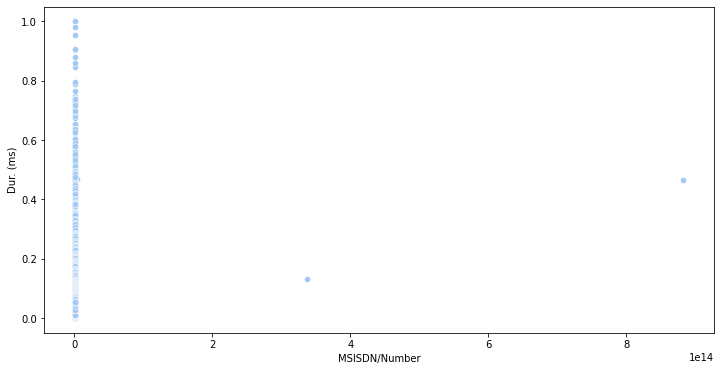

In [596]:
plt.figure(figsize=(12,6))
sns.set_palette("pastel")
sns.scatterplot(x=db_cluster['MSISDN/Number'], y = db_cluster['Dur. (ms)'], palette='bright') #data['Assault'], hue=data['Cluster'], palette='bright')

In [513]:
# db_cluster = db_encoded.copy()
# kmeans = KMeans(n_clusters=3).fit(db_cluster)
# centroids = kmeans.cluster_centers_
# print(centroids)

# # plt.scatter(db_cluster['MSISDN/Number'], db_cluster['Dur. (ms)'])#, c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# # plt.scatter(centroids[:, 0], centroids[:, 0], c='red', s=20)
# # plt.show()

# plt.figure(figsize=(12,6))
# sns.set_palette("pastel")
# sns.scatterplot(x=db_cluster['MSISDN/Number'], y = db_cluster['Dur. (ms)'], palette='bright') #data['Assault'], hue=data['Cluster'], palette='bright')
# plt.scatter(centroids[:, 0], centroids[:, 0], c='red', s=20)
# plt.show()

In [559]:
db.isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

# User Experience Analysis
* AVG TCP Retrans
* AVG RTT
* AVG TR
* Handset Type

### TCP DL Retramsmission

In [558]:
db_user_TCP_DL_RT = db.groupby(["MSISDN/Number"]).agg(TCP_DL_RT = ("TCP DL Retrans. Vol (Bytes)", 'sum')).sort_values(by='TCP_DL_RT', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TCP_DL_RT

,TCP_DL_RT
MSISDN/Number,
"41,882,819,545.03","17,642,635,928.62"
"33,667,725,464.00","8,332,732,777.00"
"33,659,084,281.00","7,938,178,623.00"
"33,660,977,522.00","7,374,100,838.00"
"33,761,284,050.00","6,039,191,773.00"
...,...
"33,761,506,920.00",4.00
"33,761,619,710.00",4.00
"33,699,002,991.00",4.00


### Top 10 TCP DL Retramsmission

In [569]:
db_user_TCP_DL_RT.head(10)

,TCP_DL_RT
MSISDN/Number,
"41,882,819,545.03","17,642,635,928.62"
"33,667,725,464.00","8,332,732,777.00"
"33,659,084,281.00","7,938,178,623.00"
"33,660,977,522.00","7,374,100,838.00"
"33,761,284,050.00","6,039,191,773.00"
"33,762,644,658.00","5,878,002,490.00"
"33,650,658,056.00","5,590,343,967.00"
"33,663,180,885.00","5,562,845,158.00"
"33,763,572,381.00","5,178,607,391.00"


### Bottom 10 TCP DL Retransmissions

In [570]:
db_user_TCP_DL_RT.tail(10)

,TCP_DL_RT
MSISDN/Number,
"33,763,992,917.00",4.00
"33,761,544,858.00",4.00
"33,669,328,368.00",4.00
"33,669,309,035.00",4.00
"33,763,938,150.00",4.00
"33,761,506,920.00",4.00
"33,761,619,710.00",4.00
"33,699,002,991.00",4.00
"33,664,535,559.00",2.00


### 10 most frequent TCP DL Reteransmissions

In [576]:
db_user_TCP_DL_RT_count = db.groupby(["MSISDN/Number"]).agg(TCP_DL_RT_Count = ("TCP DL Retrans. Vol (Bytes)", 'value_counts')).sort_values(by='TCP_DL_RT_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TCP_DL_RT_count.head(10)

,,TCP_DL_RT_Count
MSISDN/Number,TCP DL Retrans. Vol (Bytes),
"41,882,819,545.03","20,809,914.27",350
"33,625,779,332.00","20,809,914.27",12
"33,626,320,676.00","20,809,914.27",11
"33,760,536,639.00","20,809,914.27",10
"33,669,068,942.00","20,809,914.27",9
"33,676,501,152.00","20,809,914.27",9
"33,786,323,068.00","20,809,914.27",9
"33,627,080,969.00","20,809,914.27",9
"33,664,693,736.00","20,809,914.27",9


### TCP UL Retransmission

In [560]:
db_user_TCP_UL_RT = db.groupby(["MSISDN/Number"]).agg(TCP_UL_RT = ("TCP UL Retrans. Vol (Bytes)", 'sum')).sort_values(by='TCP_UL_RT', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TCP_UL_RT

,TCP_UL_RT
MSISDN/Number,
"33,669,054,076.00","5,169,346,345.66"
"33,658,249,284.00","2,637,302,536.00"
"33,763,588,772.00","2,455,599,840.00"
"33,664,698,321.00","1,751,383,517.00"
"33,665,090,461.00","1,727,810,000.00"
...,...
"33,635,265,913.00",2.00
"33,659,776,438.00",2.00
"33,642,796,046.00",1.00


### Top 10 TCP UL Retransmissions

In [573]:
db_user_TCP_UL_RT.head(10)

,TCP_UL_RT
MSISDN/Number,
"33,669,054,076.00","5,169,346,345.66"
"33,658,249,284.00","2,637,302,536.00"
"33,763,588,772.00","2,455,599,840.00"
"33,664,698,321.00","1,751,383,517.00"
"33,665,090,461.00","1,727,810,000.00"
"33,760,918,898.00","1,238,624,476.66"
"33,668,333,080.00","807,925,207.00"
"33,661,679,531.00","794,825,766.00"
"33,698,382,849.00","719,571,807.00"


### Bottom 10 TCP UL Retransmissions

In [574]:
db_user_TCP_UL_RT.tail(10)

,TCP_UL_RT
MSISDN/Number,
"33,627,130,922.00",3.00
"33,672,916,358.00",3.00
"33,665,381,941.00",3.00
"33,670,409,412.00",3.00
"33,699,595,309.00",2.00
"33,635,265,913.00",2.00
"33,659,776,438.00",2.00
"33,642,796,046.00",1.00
"33,782,587,773.00",1.00


### 10 most frequent TCP UL Reteransmissions

In [575]:
db_user_TCP_UL_RT_count = db.groupby(["MSISDN/Number"]).agg(TCP_UL_RT_Count = ("TCP UL Retrans. Vol (Bytes)", 'value_counts')).sort_values(by='TCP_UL_RT_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TCP_UL_RT_count.head(10)

TCP_UL_RT_Count
MSISDN/Number     TCP UL Retrans. Vol (Bytes)                 
41,882,819,545.03 759,658.66                               457
                  1,330.00                                  34
33,625,779,332.00 759,658.66                                16
41,882,819,545.03 2,660.00                                  15
33,667,163,239.00 759,658.66                                12
33,786,323,068.00 759,658.66                                11
33,760,536,639.00 759,658.66                                10
33,626,320,676.00 759,658.66                                10
33,669,068,942.00 759,658.66                                10
33,664,693,736.00 759,658.66                                 9

### Average RTT DL

In [561]:
db_user_RTT_DL = db.groupby(["MSISDN/Number"]).agg(AVG_RTT_DL = ("Avg RTT DL (ms)", 'sum')).sort_values(by='AVG_RTT_DL', ascending = False)#.value_counts(ascending = False) # it also works
db_user_RTT_DL

,AVG_RTT_DL
MSISDN/Number,
"41,882,819,545.03","307,586.21"
"33,662,317,023.00","96,923.00"
"33,660,874,265.00","64,666.00"
"33,683,692,867.00","54,847.00"
"33,698,551,167.00","45,923.00"
...,...
"33,652,982,188.00",0.00
"33,762,753,209.00",0.00
"33,660,637,039.00",0.00


### Top 10 Average RTT DL

In [577]:
db_user_RTT_DL.head(10)

,AVG_RTT_DL
MSISDN/Number,
"41,882,819,545.03","307,586.21"
"33,662,317,023.00","96,923.00"
"33,660,874,265.00","64,666.00"
"33,683,692,867.00","54,847.00"
"33,698,551,167.00","45,923.00"
"33,761,813,523.00","36,977.00"
"33,668,791,629.00","36,125.00"
"33,760,941,100.00","26,971.00"
"33,606,788,933.00","26,250.00"


### Bottom 10 Average RTT DL

In [578]:
db_user_RTT_DL.tail(10)

,AVG_RTT_DL
MSISDN/Number,
"33,659,493,541.00",5.00
"33,788,060,063.00",5.00
"33,695,045,499.00",4.00
"33,660,204,450.00",2.00
"33,661,575,382.00",0.00
"33,652,982,188.00",0.00
"33,762,753,209.00",0.00
"33,660,637,039.00",0.00
"33,667,477,967.00",0.00


### 10 most frequnet RTT DL

In [582]:
db_user_RTT_DL_count = db.groupby(["MSISDN/Number"]).agg(AVG_RTT_DL_Count = ("Avg RTT DL (ms)", 'value_counts')).sort_values(by='AVG_RTT_DL_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_RTT_DL_count.head(10)

AVG_RTT_DL_Count
MSISDN/Number     Avg RTT DL (ms)                  
41,882,819,545.03 109.80                        185
                  40.00                          24
                  34.00                          22
                  35.00                          20
                  41.00                          18
                  39.00                          18
                  42.00                          17
                  33.00                          17
                  45.00                          16
                  30.00                          15

### Average RTT UL

In [584]:
db_user_RTT_UL = db.groupby(["MSISDN/Number"]).agg(AVG_RTT_UL = ("Avg RTT UL (ms)", 'sum')).sort_values(by='AVG_RTT_UL', ascending = False)#.value_counts(ascending = False) # it also works
db_user_RTT_UL

,AVG_RTT_UL
MSISDN/Number,
"41,882,819,545.03","21,939.96"
"33,659,778,586.00","7,120.00"
"33,633,298,261.00","5,607.00"
"33,761,092,970.00","5,422.00"
"33,667,163,239.00","5,414.00"
...,...
"33,666,658,437.00",0.00
"33,666,666,373.00",0.00
"33,761,103,978.00",0.00


### Top 10 Average RTT UL

In [583]:
db_user_RTT_UL.head(10)


,AVG_RTT_UL
MSISDN/Number,
"41,882,819,545.03","21,939.96"
"33,659,778,586.00","7,120.00"
"33,633,298,261.00","5,607.00"
"33,761,092,970.00","5,422.00"
"33,667,163,239.00","5,414.00"
"33,627,850,141.00","5,295.00"
"33,762,057,942.00","5,248.00"
"33,668,497,162.00","4,694.66"
"33,636,368,478.00","4,038.66"


### Bottom 10 Average RTT UL

In [580]:
db_user_RTT_UL.tail(10)

,AVG_RTT_UL
MSISDN/Number,
"33,666,642,545.00",0.00
"33,666,649,347.00",0.00
"33,628,139,683.00",0.00
"33,778,070,260.00",0.00
"33,628,071,495.00",0.00
"33,666,658,437.00",0.00
"33,666,666,373.00",0.00
"33,761,103,978.00",0.00
"33,628,032,087.00",0.00


### 10 most frequent RTT UL

In [ ]:
db_user_RTT_UL_count = db.groupby(["MSISDN/Number"]).agg(AVG_RTT_UL_Count = ("Avg RTT UL (ms)", 'value_counts')).sort_values(by='AVG_RTT_UL_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_RTT_UL_count.head(10)

### Average Session DL Throughput

In [563]:

db_user_TP_DL = db.groupby(["MSISDN/Number"]).agg(AVG_TP_DL = ("Avg Bearer TP DL (kbps)", 'sum')).sort_values(by='AVG_TP_DL', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TP_DL

,AVG_TP_DL
MSISDN/Number,
"41,882,819,545.03","16,244,253.05"
"33,762,333,464.00","846,163.00"
"33,668,708,263.00","680,994.00"
"33,659,546,392.00","670,930.00"
"33,668,425,947.00","658,687.00"
...,...
"33,665,639,363.00",0.00
"33,787,829,360.00",0.00
"33,665,704,104.00",0.00


### Top 10 Session DL Throughput

In [585]:
db_user_TP_DL.head(10)

,AVG_TP_DL
MSISDN/Number,
"41,882,819,545.03","16,244,253.05"
"33,762,333,464.00","846,163.00"
"33,668,708,263.00","680,994.00"
"33,659,546,392.00","670,930.00"
"33,668,425,947.00","658,687.00"
"33,698,174,760.00","606,931.00"
"33,669,946,573.00","581,209.00"
"33,625,700,673.00","556,109.00"
"33,658,581,169.00","510,852.00"


### Bottom 10 Session DL Throughput

In [586]:
db_user_TP_DL.tail(10)

,AVG_TP_DL
MSISDN/Number,
"33,665,117,954.00",0.00
"33,665,318,260.00",0.00
"33,665,324,762.00",0.00
"33,619,834,498.00",0.00
"33,665,595,613.00",0.00
"33,665,639,363.00",0.00
"33,787,829,360.00",0.00
"33,665,704,104.00",0.00
"33,618,978,343.00",0.00


### 10 most frequent session DL Throughput

In [587]:
db_user_TP_DL_count = db.groupby(["MSISDN/Number"]).agg(AVG_TP_DL_Count = ("Avg Bearer TP DL (kbps)", 'value_counts')).sort_values(by='AVG_TP_DL_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TP_DL_count.head(10)

AVG_TP_DL_Count
MSISDN/Number     Avg Bearer TP DL (kbps)                 
41,882,819,545.03 6.00                                  64
                  0.00                                  36
                  12.00                                 10
                  8.00                                   9
                  45.00                                  8
                  35.00                                  8
33,664,119,811.00 23.00                                  6
41,882,819,545.03 56.00                                  6
                  33.00                                  6
                  20.00                                  6

### Average Session UL Throughput

In [564]:
db_user_TP_UL = db.groupby(["MSISDN/Number"]).agg(AVG_TP_UL = ("Avg Bearer TP UL (kbps)", 'sum')).sort_values(by='AVG_TP_UL', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TP_UL

,AVG_TP_UL
MSISDN/Number,
"41,882,819,545.03","1,833,980.43"
"33,658,124,130.00","167,024.00"
"33,658,075,438.00","163,585.00"
"33,763,744,937.00","161,563.00"
"33,668,708,263.00","159,430.00"
...,...
"33,660,736,208.00",0.00
"33,660,874,647.00",0.00
"33,660,916,790.00",0.00


### Top 10 Session UL Throughput

In [592]:
db_user_TP_UL.head(10)

,AVG_TP_UL
MSISDN/Number,
"41,882,819,545.03","1,833,980.43"
"33,658,124,130.00","167,024.00"
"33,658,075,438.00","163,585.00"
"33,763,744,937.00","161,563.00"
"33,668,708,263.00","159,430.00"
"33,650,520,779.00","145,320.00"
"33,763,586,476.00","138,359.00"
"33,660,394,384.00","137,330.00"
"33,659,546,392.00","127,412.00"


### Bottom 10 Session UL Throughput

In [591]:
db_user_TP_UL.tail(10)

,AVG_TP_UL
MSISDN/Number,
"33,660,706,120.00",0.00
"33,668,594,017.00",0.00
"33,668,587,519.00",0.00
"33,668,582,653.00",0.00
"33,660,724,041.00",0.00
"33,660,736,208.00",0.00
"33,660,874,647.00",0.00
"33,660,916,790.00",0.00
"33,668,544,632.00",0.00


### 10 most frequent session UL Throughput

In [589]:
db_user_TP_UL_count = db.groupby(["MSISDN/Number"]).agg(AVG_TP_UL_Count = ("Avg Bearer TP UL (kbps)", 'value_counts')).sort_values(by='AVG_TP_UL_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_TP_UL_count.head(10)

AVG_TP_UL_Count
MSISDN/Number     Avg Bearer TP UL (kbps)                 
41,882,819,545.03 9.00                                  61
                  0.00                                  25
                  19.00                                 13
                  53.00                                 12
                  54.00                                  8
                  44.00                                  8
                  47.00                                  7
                  40.00                                  7
                  29.00                                  7
                  51.00                                  6

### Handset Tyep and number of handsets used per user

In [568]:
db_user_HandsetT = db.groupby(["MSISDN/Number"]).agg(Handset_Count = ("Handset Type", 'value_counts')).sort_values(by='Handset_Count', ascending = False)#.value_counts(ascending = False) # it also works
db_user_HandsetT

Handset_Count
MSISDN/Number          Handset Type                                   
41,882,819,545.03      Huawei B528S-23A                            653
                       Samsung Galaxy S8 (Sm-G950F)                 40
                       Samsung Galaxy S7 (Sm-G930X)                 23
                       Apple iPhone 7 (A1778)                       22
                       Samsung Galaxy J3 (Sm-J330)                  20
...                                                                ...
33,660,681,821.00      Samsung Galaxy S8 (Sm-G950F)                  1
33,660,681,747.00      Samsung Galaxy S9 Sm-G960F Ds                 1
33,660,681,139.00      Apple iPhone X (A1901)                        1
33,660,680,977.00      Apple iPhone 6S (A1688)                       1
882,397,108,489,451.00 Quectel Wireless. Quectel Ec21-E              1

[106963 rows x 1 columns]

## User Experience clustering

In [602]:
# db_cluster = db_sklearn[['Avg Bearer TP UL (kbps)']]#.concat(db_user_Duration)
# kmeans = KMeans(n_clusters=3)
# kmeans.fit(db_cluster)

# centroids = kmeans.cluster_centers_
# centroids = pd.DataFrame(centroids, columns=['Avg Bearer TP UL (kbps)'])
# centroids.index = np.arange(1, len(centroids)+1) # Start the index from 1
# centroids

# plt.figure(figsize=(12,6))
# sns.set_palette("pastel")
# sns.scatterplot(x=db_cluster['MSISDN/Number'], y = db_cluster['Avg Bearer TP UL (kbps)'], palette='bright') #data['Assault'], hue=data['Cluster'], palette='bright')

### Top features for modeling

In [414]:
# col = ['Total UL (Bytes)', 'Total DL (Bytes)']
# y = db_encoded[col]
# # y

In [415]:
# len(db_encoded.columns.tolist())

In [416]:
# top_features = SelectKBest(score_func=f_regression, k=10)
# fit = top_features.fit(db_encoded, y)

# np.set_printoptions(precision=3)
# print(fit.scores_)

# for i in range(len(fit.scores_)):
# 	print('Feature %d: %f' % (i, fit.scores_[i]))
# # plot the scores
# # plt.bar([i for i in range(len(fit.scores_))], fit.scores_)
# # plt.show()

In [417]:
# xtrain,xtest, ytrain, ytest = train_test_split(db_encoded, y, test_size = 0.2, random_state=None)

# # creating scaler scale var.
# norm = MinMaxScaler()
# # fit the scal
# norm_fit = norm.fit(xtrain)
# pickle.dump(norm_fit, open("train_set.pkl", 'wb'))
# dump(norm_fit,'train_set.joblib')
# # transfromation of trainig data
# scal_xtrain_set = norm_fit.transform(xtrain)

# # transformation of testing data
# scal_xtest_set = norm_fit.transform(xtest)
# print(scal_xtrain_set)  

#### Fit the model with RandomForest classifier

In [418]:
# rnd_forest = RandomForestClassifier()
# # model = KMeans(n_clusters = 3)
  
# # fit the model
# # fit_rnd = rnd_forest.fit(xtrain,ytrain) 